In [3]:
import kgeo
import numpy as np
import matplotlib.pyplot as plt
from aart_func import *
from params import * # The file params.py contains all the relevant parameters for the simulations
from astropy import units as u
import tools as tls
import subprocess
import scipy.interpolate
%load_ext autoreload
%autoreload 2
import importlib 


Welcome to eht-imaging! v 1.2.5 


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca



In [6]:

def curve_params(varphi, rho):
    """calculate Appendix B parameters for a curve rho(varphi)
       assume varphis are equally spaced!!!"""
          
    # spacing in varphi  
    dvarphi = varphi[-1]-varphi[-2]
    
    # area
    area = np.trapz(0.5*rho**2,dx=dvarphi)
    
    # centroid
    mux = np.trapz((rho**3*np.cos(varphi)) / (3*area), dx=dvarphi)
    muy = np.trapz((rho**3*np.sin(varphi)) / (3*area), dx=dvarphi)  

    # second moment
    Sxx = np.trapz((rho**4*np.cos(varphi)**2) / (4*area), dx=dvarphi) - mux**2
    Syy = np.trapz((rho**4*np.sin(varphi)**2) / (4*area), dx=dvarphi) - muy**2
    Sxy = np.trapz((rho**4*np.sin(varphi)*np.cos(varphi)) / (4*area), dx=dvarphi) - mux*muy
    
    # diagonalize 2nd moment matrix
    D = np.sqrt((Sxx-Syy)**2 + 4*Sxy*Sxy)
    a = np.sqrt(2*(Sxx + Syy + D))
    b = np.sqrt(2*(Sxx + Syy - D))
    
    #radius, eccentricity, position angle
    r = np.sqrt(0.5*(a**2 + b**2))
    e = np.sqrt(1-b**2/a**2)
    chi = 0.5*np.arcsin(2*Sxy/D)
    
    return (area, mux, muy, r, e, chi)    
    


In [9]:
I0 = np.load('I0.npy')

In [7]:
a = 0.94        
inc = 17*np.pi/180. # inclination angle
rh = 1 + np.sqrt(1-a**2) # event horizon

print("spin %0.2f, inclination %0.2f, horizon %0.2f\n"%(a,inc*180/np.pi,rh))
print("computing curves....\n")
# angles to sample
varphis = np.linspace(-180,179,360)*np.pi/180


# generate inner shadow (n=0) curve with kgeo
data_inner = kgeo.equatorial_lensing.rho_of_req(a,inc,rh,mbar=0,varphis=varphis)
(_, rhos_inner, alphas_inner, betas_inner) = data_inner

# generate outer shadow (n=inf) curve with kgeo
data_outer = kgeo.equatorial_lensing.rho_of_req(a,inc,rh,mbar=5,varphis=varphis)
(_, rhos_outer, alphas_outer, betas_outer) = data_outer




spin 0.94, inclination 17.00, horizon 1.34

computing curves....



NameError: name 'mux_inner' is not defined

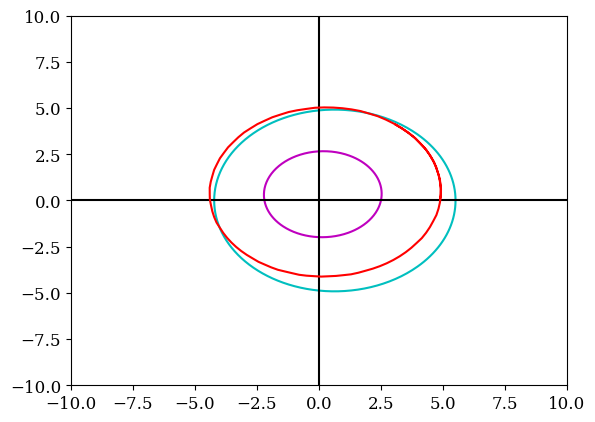

In [10]:
# plot the inner and outer shadow
plt.ion()
plt.figure()
plt.plot(alphas_outer, betas_outer, ls='-', color='c')
plt.plot(alphas_inner, betas_inner, ls='-', color='m')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.axhline(0,-100,100,color='k')
plt.axvline(0,-100,100,color='k')


theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1) / 100)
radii = np.array(tls.radii_of_theta(I0,100))

alpha =  radii * np.cos(theta)
beta =  radii * np.sin(theta)
plt.plot(alpha, beta, 'r')
plt.scatter(mux_inner, muy_outer)
plt.show()


In [107]:
# compute curve parameters
(area_inner, mux_inner, muy_inner, r_inner, e_inner, chi_inner) = curve_params(varphis,rhos_inner)
(area_outer, mux_outer, muy_outer, r_outer, e_outer, chi_outer) = curve_params(varphis,rhos_outer)

r_inner = np.load('r_inner.npy')
print("inner shadow")
print("===========================")
print("area: %0.2f"%area_inner)
print("centroid: %0.2f, %0.2f"%(mux_inner, muy_inner))
print("radius: %0.2f"%r_inner)
print("eccentricity: %0.2f"%e_inner)
print("position angle: %0.2f"%(chi_inner*180/np.pi))  

print("\n outer shadow")
print("===========================")
print("area: %0.2f"%area_outer)
print("centroid: %0.2f, %0.2f"%(mux_outer, muy_outer))
print("radius: %0.2f"%r_outer)
print("eccentricity: %0.2f"%e_outer)
print("position angle: %0.2f"%(chi_outer*180/np.pi))  

print("===========================")
thetatotal = 100
varphi = np.arange( 2 * np.pi + 1, step=(2*np.pi + 1)/thetatotal)
rho = tls.radii_of_theta(I0, thetatotal)
(area, mux, muy, r, e, chi) = curve_params(varphi, rho)
print('r = ' + str(r))
print('e = ' + str(e))
print('centroid =  ({}, {})'.format(mux, muy))
print('area =  {}'.format(area))

inner shadow
area: 17.31
centroid: 0.16, 0.34
radius: 2.35
eccentricity: 0.20
position angle: 15.92

 outer shadow
area: 75.03
centroid: 0.64, -0.00
radius: 4.89
eccentricity: 0.16
position angle: 0.07
r = 2.2829489044029883
e = 0.47048608496711514
centroid =  (0.3258852948439373, 0.3052811811395245)
area =  19.719513725804532
